In [ ]:
!pip install pandas numpy yfinance polars pyarrow matplotlib seaborn numpy-financial


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import yfinance as yf
import polars as pl
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.grid"] = True

In [ ]:
import yfinance as yf

stock = "IOLCP.BO"

try:
    ticker = yf.Ticker(stock)
    data = ticker.history(period="1y")
    
    if data.empty:
        print(f"No data available for {stock}")
    else:
        print(f"Downloaded {len(data)} days of market data for {stock}")
        print(f"Date range: {data.index.min().date()} to {data.index.max().date()}")
except Exception as e:
    print(f"Error fetching stock data: {e}")

Downloaded 249 days of market data for IOLCP.BO
Date range: 2024-05-23 to 2025-05-23


In [ ]:
if not data.empty:
    data = data.reset_index()
    data.columns = [str(col) for col in data.columns]
    
    print(f"Summary statistics:")
    print(f"Average Close price: ${data['Close'].mean():.2f}")
    print(f"Min/Max Close: ${data['Close'].min():.2f} / ${data['Close'].max():.2f}")

Summary statistics:
Average Close price: $74.49
Min/Max Close: $59.31 / $97.21


In [ ]:
df = pl.from_pandas(data)

In [26]:
print(df)

shape: (249, 8)
┌──────────────┬───────────┬───────────┬───────────┬───────────┬────────┬───────────┬──────────────┐
│ Date         ┆ Open      ┆ High      ┆ Low       ┆ Close     ┆ Volume ┆ Dividends ┆ Stock Splits │
│ ---          ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---    ┆ ---       ┆ ---          │
│ datetime[ns, ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ i64    ┆ f64       ┆ f64          │
│ Asia/Kolkata ┆           ┆           ┆           ┆           ┆        ┆           ┆              │
│ ]            ┆           ┆           ┆           ┆           ┆        ┆           ┆              │
╞══════════════╪═══════════╪═══════════╪═══════════╪═══════════╪════════╪═══════════╪══════════════╡
│ 2024-05-23   ┆ 70.599881 ┆ 71.032893 ┆ 69.752681 ┆ 69.903297 ┆ 56030  ┆ 0.0       ┆ 0.0          │
│ 00:00:00 IST ┆           ┆           ┆           ┆           ┆        ┆           ┆              │
│ 2024-05-24   ┆ 69.809168 ┆ 70.392789 ┆ 69.667967 ┆ 69.969193 ┆ 39080  ┆ 0

In [ ]:
df = df.select([
    pl.col("Date"),
    pl.col("Open"),
    pl.col("High"),
    pl.col("Low"),
    pl.col("Close"),
    pl.col("Volume"),
    (pl.col("Close") - pl.col("Open")).alias("Day_Change"),
    ((pl.col("Close") - pl.col("Open")) / pl.col("Open") * 100).alias("Day_Change_%")
])

In [28]:
print(df)

shape: (249, 8)
┌──────────────┬───────────┬───────────┬───────────┬───────────┬────────┬────────────┬─────────────┐
│ Date         ┆ Open      ┆ High      ┆ Low       ┆ Close     ┆ Volume ┆ Day_Change ┆ Day_Change_ │
│ ---          ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---    ┆ ---        ┆ %           │
│ datetime[ns, ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ i64    ┆ f64        ┆ ---         │
│ Asia/Kolkata ┆           ┆           ┆           ┆           ┆        ┆            ┆ f64         │
│ ]            ┆           ┆           ┆           ┆           ┆        ┆            ┆             │
╞══════════════╪═══════════╪═══════════╪═══════════╪═══════════╪════════╪════════════╪═════════════╡
│ 2024-05-23   ┆ 70.599881 ┆ 71.032893 ┆ 69.752681 ┆ 69.903297 ┆ 56030  ┆ -0.696583  ┆ -0.986664   │
│ 00:00:00 IST ┆           ┆           ┆           ┆           ┆        ┆            ┆             │
│ 2024-05-24   ┆ 69.809168 ┆ 70.392789 ┆ 69.667967 ┆ 69.969193 ┆ 39080  ┆ 0

In [ ]:
def detect_signal(df_dicts):
    signals = []

    for i in range(2, len(df_dicts)):
        d0 = df_dicts[i - 2]
        d1 = df_dicts[i - 1]
        d2 = df_dicts[i]
        
        signal = "None"
        stoploss = None

        if (d0["Close"] < d0["Open"] and
            d1["Close"] < d1["Open"] and
            d2["Close"] > d2["Open"]):
            
            body_size = abs(d2["Close"] - d2["Open"])
            
            stoploss = round(d2["Close"] - 0.5 * body_size, 2)
            signal = "Buy"

        signals.append({
            "Date": d2["Date"],
            "Signal": signal,
            "Stoploss": stoploss,
            "Price": d2["Close"],
            "Open": d2["Open"],
            "High": d2["High"],
            "Low": d2["Low"]
        })

    return pl.DataFrame(signals)

In [ ]:
signals = detect_signal(df.to_dicts())

buy_signals = signals.filter(pl.col("Signal") == "Buy")
print(f"Total data points: {len(signals)}")
print(f"Total buy signals: {len(buy_signals)}")
print(f"Buy signal frequency: {len(buy_signals)/len(signals)*100:.2f}%")

Total data points: 247
Total buy signals: 36
Buy signal frequency: 14.57%


In [31]:
print(signals)

shape: (247, 7)
┌────────────────────────────┬────────┬──────────┬───────────┬───────────┬───────────┬───────────┐
│ Date                       ┆ Signal ┆ Stoploss ┆ Price     ┆ Open      ┆ High      ┆ Low       │
│ ---                        ┆ ---    ┆ ---      ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ datetime[μs, Asia/Kolkata] ┆ str    ┆ f64      ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════════════════════════╪════════╪══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2024-05-27 00:00:00 IST    ┆ None   ┆ null     ┆ 69.63031  ┆ 69.988014 ┆ 70.552811 ┆ 69.376146 │
│ 2024-05-28 00:00:00 IST    ┆ None   ┆ null     ┆ 68.143005 ┆ 69.630311 ┆ 70.035084 ┆ 67.785302 │
│ 2024-05-29 00:00:00 IST    ┆ Buy    ┆ 68.24    ┆ 68.707802 ┆ 67.775885 ┆ 69.752681 ┆ 67.775885 │
│ 2024-05-30 00:00:00 IST    ┆ None   ┆ null     ┆ 67.502899 ┆ 68.867835 ┆ 69.347909 ┆ 67.371113 │
│ 2024-05-31 00:00:00 IST    ┆ None   ┆ null     ┆ 67.700577 ┆ 67.907671 ┆ 68.143004 ┆ 67.446

In [ ]:
def generate_PNL(signals_df):
    trades = []
    holdings = False
    entry = {}

    signal_dicts = signals_df.to_dicts()
    for i in range(len(signal_dicts) - 1):
        sig = signal_dicts[i]
        next_day = signal_dicts[i + 1]

        if sig["Signal"] == "Buy" and not holdings:
            entry = {
                "Entry_Date": sig["Date"],
                "Entry_Price": sig["Price"],
                "Stoploss": sig["Stoploss"]
            }
            holdings = True

        elif holdings and (next_day["Signal"] != "Buy" or i == len(signal_dicts) - 2):
            exit_price = next_day["Price"]
            pnl = exit_price - entry["Entry_Price"]
            pnl_percent = (pnl / entry["Entry_Price"]) * 100
            dd = min(0, pnl)
            dd_percent = min(0, pnl_percent)

            trades.append({
                "Entry_Date": entry["Entry_Date"],
                "Entry_Price": entry["Entry_Price"],
                "Stoploss": entry["Stoploss"],
                "Exit_Date": next_day["Date"],
                "Exit_Price": round(exit_price, 2),
                "PNL": round(pnl, 2),
                "PNL%": round(pnl_percent, 2),
                "DD": round(dd, 2),
                "DD%": round(dd_percent, 2),
                "Trade_Duration": (next_day["Date"] - entry["Entry_Date"]).days
            })
            holdings = False

    return pl.DataFrame(trades)

In [ ]:
pnl_report = generate_PNL(signals)

In [ ]:
print(pnl_report)

if len(pnl_report) > 0:
    winning_trades = pnl_report.filter(pl.col("PNL") > 0)
    losing_trades = pnl_report.filter(pl.col("PNL") < 0)
    
    total_trades = len(pnl_report)
    win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
    
    print(f"\nPerformance Summary:")
    print(f"Total Trades: {total_trades}")
    print(f"Winning Trades: {len(winning_trades)} ({win_rate:.2f}%)")
    print(f"Losing Trades: {len(losing_trades)} ({100-win_rate:.2f}%)")
    
    if len(winning_trades) > 0:
        avg_win = winning_trades.select(pl.mean("PNL%")).item()
        print(f"Average Win: {avg_win:.2f}%")
        
    if len(losing_trades) > 0:
        avg_loss = losing_trades.select(pl.mean("PNL%")).item()
        print(f"Average Loss: {avg_loss:.2f}%")
        
    total_pnl = pnl_report.select(pl.sum("PNL")).item()
    print(f"Total P&L: ${total_pnl:.2f}")
    
    avg_duration = pnl_report.select(pl.mean("Trade_Duration")).item()
    print(f"Average Trade Duration: {avg_duration:.1f} days")

shape: (36, 10)
┌───────────────┬─────────────┬──────────┬──────────────┬───┬───────┬───────┬───────┬──────────────┐
│ Entry_Date    ┆ Entry_Price ┆ Stoploss ┆ Exit_Date    ┆ … ┆ PNL%  ┆ DD    ┆ DD%   ┆ Trade_Durati │
│ ---           ┆ ---         ┆ ---      ┆ ---          ┆   ┆ ---   ┆ ---   ┆ ---   ┆ on           │
│ datetime[μs,  ┆ f64         ┆ f64      ┆ datetime[μs, ┆   ┆ f64   ┆ f64   ┆ f64   ┆ ---          │
│ Asia/Kolkata] ┆             ┆          ┆ Asia/Kolkata ┆   ┆       ┆       ┆       ┆ i64          │
│               ┆             ┆          ┆ ]            ┆   ┆       ┆       ┆       ┆              │
╞═══════════════╪═════════════╪══════════╪══════════════╪═══╪═══════╪═══════╪═══════╪══════════════╡
│ 2024-05-29    ┆ 68.707802   ┆ 68.24    ┆ 2024-05-31   ┆ … ┆ -1.47 ┆ -1.01 ┆ -1.47 ┆ 2            │
│ 00:00:00 IST  ┆             ┆          ┆ 00:00:00 IST ┆   ┆       ┆       ┆       ┆              │
│ 2024-06-05    ┆ 66.862793   ┆ 66.31    ┆ 2024-06-07   ┆ … ┆ 3.32  ┆ 0.0  

In [39]:
if len(pnl_report) > 0:
    pnl_pd = pnl_report.to_pandas()
    pnl_pd['Entry_Date'] = pd.to_datetime(pnl_pd['Entry_Date'])
    pnl_pd['Exit_Date'] = pd.to_datetime(pnl_pd['Exit_Date'])
    
    pnl_pd['Year'] = pnl_pd['Entry_Date'].dt.year
    
    if len(pnl_pd) > 1:
        trading_days = (pnl_pd['Exit_Date'].max() - pnl_pd['Entry_Date'].min()).days
        years = trading_days / 365.0
        months = trading_days / 30.0
    else:
        years = 1
        months = 1
    
    total_pnl_points = pnl_report.select(pl.sum("PNL")).item()
    max_drawdown_points = pnl_report.select(pl.min("DD")).item()
    
    total_pnl_percent = pnl_report.select(pl.sum("PNL%")).item()
    max_drawdown_percent = pnl_report.select(pl.min("DD%")).item()
    
    winning_probability = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
    
    pnl_percent_per_year = total_pnl_percent / years if years > 0 else 0
    trades_per_month = total_trades / months if months > 0 else 0
    
    pnl_dd_ratio = abs(total_pnl_percent / max_drawdown_percent) if max_drawdown_percent != 0 else float('inf')
    
    pnl_list = pnl_pd['PNL'].tolist()
    max_consecutive_wins = 0
    max_consecutive_losses = 0
    current_win_streak = 0
    current_loss_streak = 0
    
    for pnl in pnl_list:
        if pnl > 0:
            current_win_streak += 1
            current_loss_streak = 0
            max_consecutive_wins = max(max_consecutive_wins, current_win_streak)
        elif pnl < 0:
            current_loss_streak += 1
            current_win_streak = 0
            max_consecutive_losses = max(max_consecutive_losses, current_loss_streak)
        else:  # pnl == 0
            current_win_streak = 0
            current_loss_streak = 0
    
    avg_positive_pnl = pnl_pd[pnl_pd['PNL'] > 0]['PNL'].mean() if len(winning_trades) > 0 else 0
    avg_negative_pnl = pnl_pd[pnl_pd['PNL'] < 0]['PNL'].mean() if len(losing_trades) > 0 else 0
    
    print("\nAdditional Performance Metrics:")
    print(f"PNL in Points: {total_pnl_points:.2f}")
    print(f"DD in Points: {max_drawdown_points:.2f}")
    print(f"PNL% in Points: {total_pnl_percent:.2f}")
    print(f"DD% in Points: {max_drawdown_percent:.2f}")
    print(f"Years of Trading: {years:.2f}")
    print(f"Total Trades: {total_trades}")
    print(f"Winning Probability: {winning_probability:.2f}%")
    print(f"PNL%/Year: {pnl_percent_per_year:.2f}")
    print(f"Trades/Month: {trades_per_month:.2f}")
    print(f"PNL%/DD% Ratio: {pnl_dd_ratio:.2f}")
    print(f"Max Consecutive Win Trades: {max_consecutive_wins}")
    print(f"Max Consecutive Loss Trades: {max_consecutive_losses}")
    print(f"Avg of Positive PNL: ${avg_positive_pnl:.2f}")
    print(f"Avg of Negative PNL: ${avg_negative_pnl:.2f}")


Additional Performance Metrics:
PNL in Points: 0.44
DD in Points: -5.55
PNL% in Points: 8.41
DD% in Points: -6.68
Years of Trading: 0.98
Total Trades: 36
Winning Probability: 52.78%
PNL%/Year: 8.55
Trades/Month: 3.01
PNL%/DD% Ratio: 1.26
Max Consecutive Win Trades: 6
Max Consecutive Loss Trades: 4
Avg of Positive PNL: $2.07
Avg of Negative PNL: $-2.28


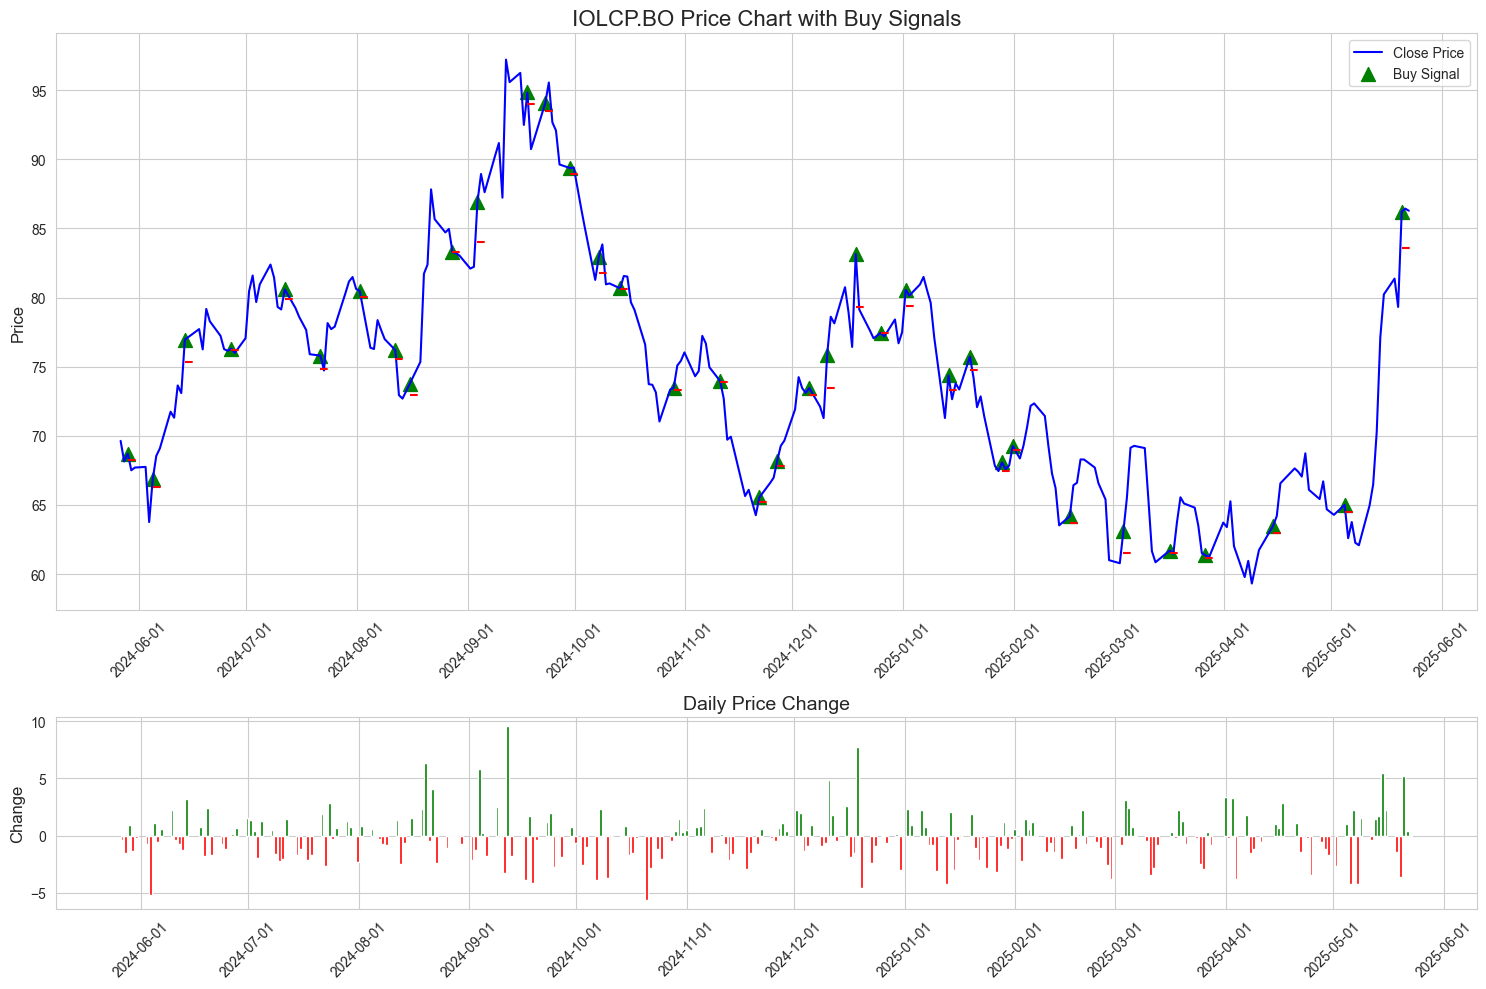

In [ ]:
signals_pd = signals.to_pandas()
signals_pd['Date'] = pd.to_datetime(signals_pd['Date'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(signals_pd['Date'], signals_pd['Price'], label='Close Price', color='blue')

buy_signals_pd = signals_pd[signals_pd['Signal'] == 'Buy']
ax1.scatter(buy_signals_pd['Date'], buy_signals_pd['Price'], 
           color='green', marker='^', s=100, label='Buy Signal')

for _, row in buy_signals_pd.iterrows():
    if row['Stoploss'] is not None:
        ax1.hlines(row['Stoploss'], row['Date'], 
                 row['Date'] + pd.Timedelta(days=3), 
                 colors='red', linestyles='dashed')

ax1.set_title(f'{stock} Price Chart with Buy Signals', fontsize=16)
ax1.set_ylabel('Price', fontsize=12)
ax1.legend()
ax1.grid(True)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

ax2.bar(signals_pd['Date'], signals_pd['Price'] - signals_pd['Open'], 
       color=signals_pd.apply(lambda x: 'green' if x['Price'] > x['Open'] else 'red', axis=1))
ax2.set_title('Daily Price Change', fontsize=14)
ax2.set_ylabel('Change', fontsize=12)
ax2.grid(True)

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

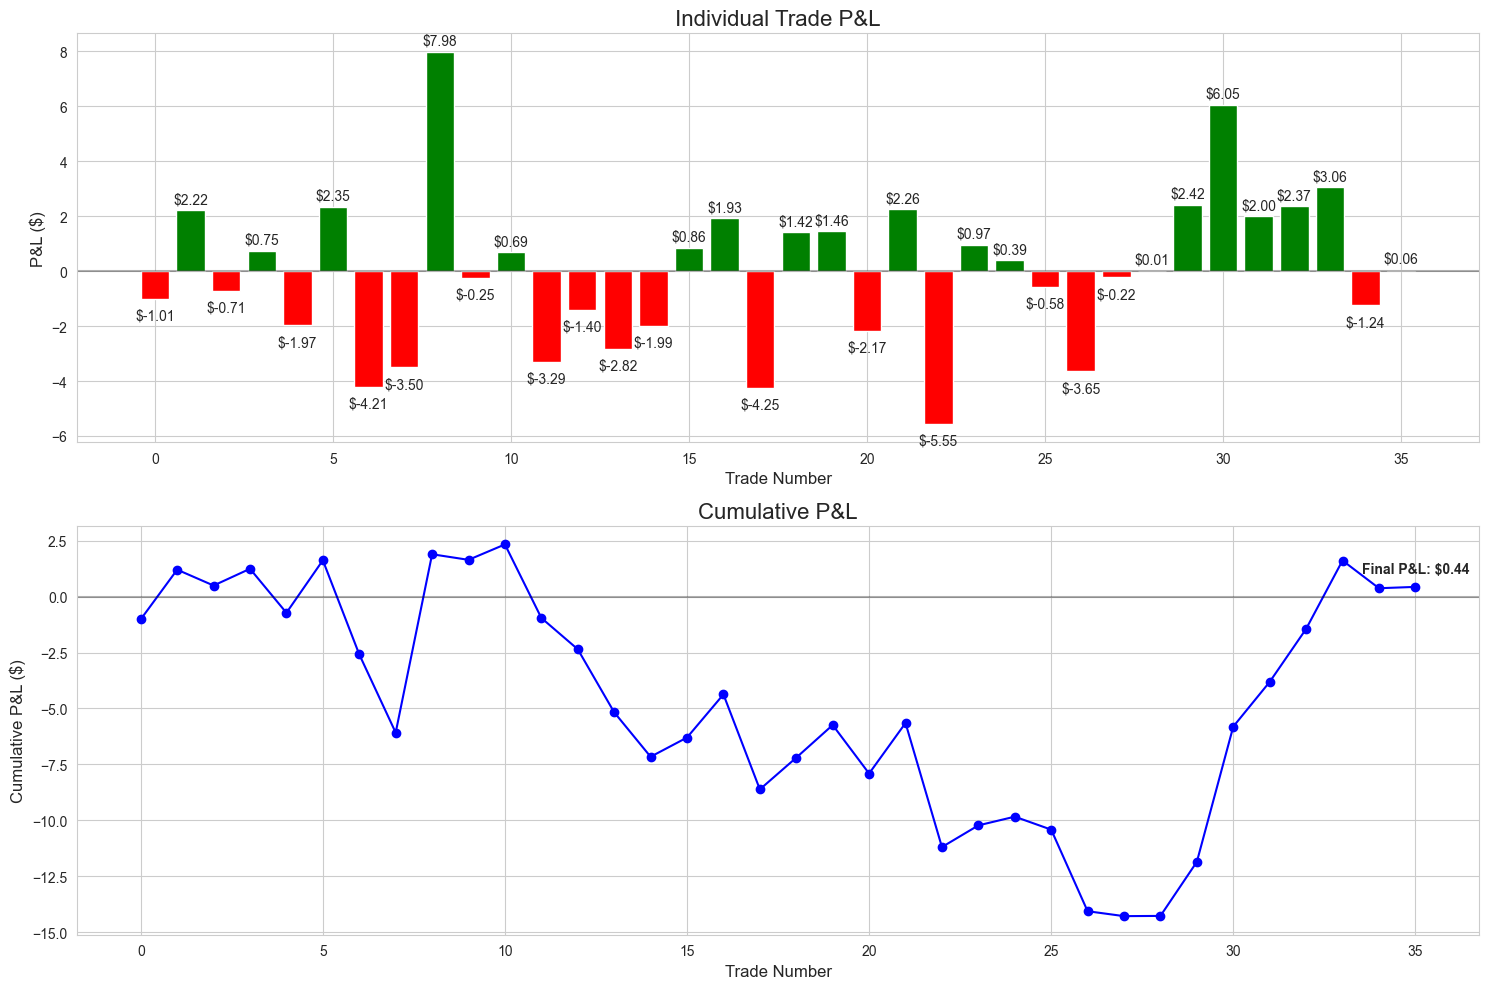

In [ ]:
if len(pnl_report) > 0:
    pnl_pd = pnl_report.to_pandas()
    pnl_pd['Entry_Date'] = pd.to_datetime(pnl_pd['Entry_Date'])
    pnl_pd['Exit_Date'] = pd.to_datetime(pnl_pd['Exit_Date'])
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    colors = ['green' if pnl > 0 else 'red' for pnl in pnl_pd['PNL']]
    ax1.bar(range(len(pnl_pd)), pnl_pd['PNL'], color=colors)
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax1.set_title('Individual Trade P&L', fontsize=16)
    ax1.set_xlabel('Trade Number', fontsize=12)
    ax1.set_ylabel('P&L ($)', fontsize=12)
    
    for i, pnl in enumerate(pnl_pd['PNL']):
        ax1.annotate(f'${pnl:.2f}', 
                   (i, pnl), 
                   textcoords="offset points", 
                   xytext=(0, 5 if pnl >= 0 else -15),
                   ha='center')
    
    cumulative_pnl = pnl_pd['PNL'].cumsum()
    ax2.plot(range(len(cumulative_pnl)), cumulative_pnl, marker='o', color='blue')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_title('Cumulative P&L', fontsize=16)
    ax2.set_xlabel('Trade Number', fontsize=12)
    ax2.set_ylabel('Cumulative P&L ($)', fontsize=12)
    ax2.grid(True)
    
    if len(cumulative_pnl) > 0:
        ax2.annotate(f'Final P&L: ${cumulative_pnl.iloc[-1]:.2f}', 
                   xy=(len(cumulative_pnl)-1, cumulative_pnl.iloc[-1]),
                   textcoords="offset points", 
                   xytext=(0, 10),
                   ha='center',
                   fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("No trades to visualize")

In [ ]:
# Visualization of additional metrics
if len(pnl_report) > 0:
    # Year-wise analysis
    pnl_pd['Year'] = pnl_pd['Entry_Date'].dt.year
    year_stats = pnl_pd.groupby('Year').agg({
        'PNL': ['sum', 'mean'],
        'PNL%': ['sum', 'mean'],
        'Entry_Date': 'count'
    })
    year_stats.columns = ['PNL_Sum', 'PNL_Mean', 'PNL%_Sum', 'PNL%_Mean', 'Trade_Count']
    year_stats.reset_index(inplace=True)
    
    # Create figure with multiple subplots for additional metrics
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Plot 1: Year-wise PnL
    if len(year_stats) > 0:
        ax1 = axes[0, 0]
        colors = ['green' if pnl > 0 else 'red' for pnl in year_stats['PNL_Sum']]
        ax1.bar(year_stats['Year'].astype(str), year_stats['PNL_Sum'], color=colors)
        ax1.set_title('Year-wise PnL', fontsize=16)
        ax1.set_xlabel('Year', fontsize=12)
        ax1.set_ylabel('PnL ($)', fontsize=12)
        
        for i, pnl in enumerate(year_stats['PNL_Sum']):
            ax1.annotate(f'${pnl:.2f}', 
                       (i, pnl), 
                       textcoords="offset points", 
                       xytext=(0, 5 if pnl >= 0 else -15),
                       ha='center')
    
    # Plot 2: Trade Count by Year
    if len(year_stats) > 0:
        ax2 = axes[0, 1]
        ax2.bar(year_stats['Year'].astype(str), year_stats['Trade_Count'], color='blue')
        ax2.set_title('Trades per Year', fontsize=16)
        ax2.set_xlabel('Year', fontsize=12)
        ax2.set_ylabel('Number of Trades', fontsize=12)
        
        for i, count in enumerate(year_stats['Trade_Count']):
            ax2.annotate(f'{count}', 
                       (i, count), 
                       textcoords="offset points", 
                       xytext=(0, 5),
                       ha='center')
    
    # Plot 3: Win/Loss Distribution
    ax3 = axes[1, 0]
    labels = ['Wins', 'Losses']
    sizes = [len(winning_trades), len(losing_trades)]
    colors = ['green', 'red']
    explode = (0.1, 0)  # explode the 1st slice (Wins)
    
    ax3.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=90)
    ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    ax3.set_title('Win/Loss Distribution', fontsize=16)
    
    # Plot 4: Key Performance Indicators
    ax4 = axes[1, 1]
    ax4.axis('off')  # Turn off the axis
    
    # Create a table of KPIs
    kpi_data = [
        ['Metric', 'Value'],
        ['Winning Probability', f'{winning_probability:.2f}%'],
        ['PNL%/Year', f'{pnl_percent_per_year:.2f}'],
        ['Trades/Month', f'{trades_per_month:.2f}'],
        ['PNL%/DD% Ratio', f'{pnl_dd_ratio:.2f}'],
        ['Max Consecutive Wins', f'{max_consecutive_wins}'],
        ['Max Consecutive Losses', f'{max_consecutive_losses}'],
        ['Avg +PNL', f'${avg_positive_pnl:.2f}'],
        ['Avg -PNL', f'${avg_negative_pnl:.2f}']
    ]
    
    table = ax4.table(cellText=kpi_data, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)  # Adjust table size
    for i in range(len(kpi_data)):
        table.auto_set_column_width([0, 1])
    
    # Style the header row
    for k, cell in table._cells.items():
        if k[0] == 0:  # Header row
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('darkblue')
        else:  # Value rows - alternate colors for readability
            if k[0] % 2 == 0:
                cell.set_facecolor('lightgray')
    
    plt.tight_layout()
    plt.show()

# Technical Indicators Backtesting

We'll implement and backtest the following technical indicators:
1. SMA (Simple Moving Average)
2. EMA (Exponential Moving Average)
3. RSI (Relative Strength Index)
4. MACD (Moving Average Convergence Divergence)
5. MFI (Money Flow Index)
6. Keltner Channel
7. ADX (Average Directional Index)
8. Red Candle Condition
9. Supertrend

Each indicator will be tested with appropriate entry and exit rules, and we'll generate performance reports including PnL analysis.

In [ ]:
# Install additional libraries for technical indicators - already installed in the first cell
print("Technical indicators will be calculated using NumPy and Pandas built-in functions.")


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/115.1 kB ? eta -:--:--
     --- ------------------------------------ 10.2/115.1 kB ? eta -:--:--
     ------ ------------------------------ 20.5/115.1 kB 330.3 kB/s eta 0:00:01
     -----------------------------------  112.6/115.1 kB 939.4 kB/s eta 0:00:01
     -----------------------------------  112.6/115.1 kB 939.4 kB/s eta 0:00:01
     ------------------------------------ 115.1/115.1 kB 560.7 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218927 sha256=60ab8221aeca8789444446c1dad8eb82d5b95077da977c26d8e3ed3085de3b77
  Stored in directory: c:\users\abc\appdata\local\pip\cache\wheels\fd\ed\18\2a12fd1b7906c63efca6accb351929f2c7f6bbc674e1c0ba5d
Successfully built pandas_ta


In [ ]:
import numpy as np
import pandas as pd

def calculate_indicators(df_pandas):
    """Calculate all technical indicators for the dataframe"""
    # Convert to pandas for indicator calculations
    df = df_pandas.copy()
    
    # 1. SMA - Simple Moving Average
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    
    # 2. EMA - Exponential Moving Average
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()
    
    # 3. RSI - Relative Strength Index
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # 4. MACD - Moving Average Convergence Divergence
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']
    
    # 5. MFI - Money Flow Index
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    money_flow = typical_price * df['Volume']
    
    positive_flow = []
    negative_flow = []
    
    for i in range(1, len(df)):
        if typical_price.iloc[i] > typical_price.iloc[i-1]:  # Fixed indexing
            positive_flow.append(money_flow.iloc[i])  # Fixed indexing
            negative_flow.append(0)
        elif typical_price.iloc[i] < typical_price.iloc[i-1]:  # Fixed indexing
            positive_flow.append(0)
            negative_flow.append(money_flow.iloc[i])  # Fixed indexing
        else:
            positive_flow.append(0)
            negative_flow.append(0)
    
    # Insert 0 at index 0
    positive_flow.insert(0, 0)
    negative_flow.insert(0, 0)
    
    # Convert lists to Series with the same index as df
    df['Positive_Flow'] = pd.Series(positive_flow, index=df.index)
    df['Negative_Flow'] = pd.Series(negative_flow, index=df.index)
    
    df['Positive_Flow_14'] = df['Positive_Flow'].rolling(window=14).sum()
    df['Negative_Flow_14'] = df['Negative_Flow'].rolling(window=14).sum()
    
    # Avoid division by zero
    money_flow_ratio = df['Positive_Flow_14'] / (df['Negative_Flow_14'] + 1e-9)
    df['MFI'] = 100 - (100 / (1 + money_flow_ratio))
    
    # 6. Keltner Channel
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['ATR'] = df_pandas['High'] - df_pandas['Low']  # Simple version of ATR
    df['ATR'] = df['ATR'].rolling(window=10).mean()
    df['Keltner_Upper'] = df['EMA_20'] + (df['ATR'] * 2)
    df['Keltner_Lower'] = df['EMA_20'] - (df['ATR'] * 2)
    
    # 7. ADX - Average Directional Index (simplified implementation)
    # Calculating True Range
    df['TR'] = np.maximum(
        df['High'] - df['Low'],
        np.maximum(
            np.abs(df['High'] - df['Close'].shift(1)),
            np.abs(df['Low'] - df['Close'].shift(1))
        )
    )
    
    # Directional Movement
    df['DMplus'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                         np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['DMminus'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                          np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)
    
    # Smoothed values
    df['smoothed_TR'] = df['TR'].rolling(window=14).sum()
    df['smoothed_DMplus'] = df['DMplus'].rolling(window=14).sum()
    df['smoothed_DMminus'] = df['DMminus'].rolling(window=14).sum()
    
    # Directional Indicators
    df['DI_plus'] = 100 * df['smoothed_DMplus'] / (df['smoothed_TR'] + 1e-9)
    df['DI_minus'] = 100 * df['smoothed_DMminus'] / (df['smoothed_TR'] + 1e-9)
    
    # Directional Index
    df['DX'] = 100 * np.abs(df['DI_plus'] - df['DI_minus']) / (df['DI_plus'] + df['DI_minus'] + 1e-9)
    
    # Average Directional Index
    df['ADX'] = df['DX'].rolling(window=14).mean()
    
    # 8. Red Candle Condition
    df['Red_Candle'] = (df['Close'] < df['Open']).astype(int)
    df['Red_Candle_Count'] = df['Red_Candle'].rolling(window=3).sum()
    
    # 9. Supertrend
    factor = 3
    atr_period = 10
    
    # Calculate ATR (more accurate version)
    hl = df['High'] - df['Low']
    hc = np.abs(df['High'] - df['Close'].shift())
    lc = np.abs(df['Low'] - df['Close'].shift())
    
    tr = pd.concat([hl, hc, lc], axis=1).max(axis=1)
    atr = tr.rolling(atr_period).mean()
    
    # Calculate Supertrend
    df['ATR'] = atr
    df['Upper_Band'] = ((df['High'] + df['Low']) / 2) + (factor * df['ATR'])
    df['Lower_Band'] = ((df['High'] + df['Low']) / 2) - (factor * df['ATR'])
    
    df['Supertrend'] = 0.0
    
    # First value of Supertrend
    if len(df) > 1:
        if df['Close'].iloc[1] <= df['Upper_Band'].iloc[1]:
            df['Supertrend'].iloc[1] = df['Upper_Band'].iloc[1]
        else:
            df['Supertrend'].iloc[1] = df['Lower_Band'].iloc[1]
    
    # Calculate Supertrend for the rest of the data
    for i in range(2, len(df)):
        curr = df.iloc[i]
        prev = df.iloc[i-1]
        
        # Current close crosses above upper band
        if curr['Close'] > prev['Upper_Band']:
            df.loc[df.index[i], 'Supertrend'] = 1  # Uptrend
        # Current close crosses below lower band
        elif curr['Close'] < prev['Lower_Band']:
            df.loc[df.index[i], 'Supertrend'] = -1  # Downtrend
        else:
            # Continue previous trend
            df.loc[df.index[i], 'Supertrend'] = df.loc[df.index[i-1], 'Supertrend']
            
            # Check for trend reversal
            if df.loc[df.index[i], 'Supertrend'] == 1 and curr['Close'] < prev['Lower_Band']:
                df.loc[df.index[i], 'Supertrend'] = -1
            elif df.loc[df.index[i], 'Supertrend'] == -1 and curr['Close'] > prev['Upper_Band']:
                df.loc[df.index[i], 'Supertrend'] = 1
    
    # Drop intermediate calculation columns
    intermediate_cols = ['Positive_Flow', 'Negative_Flow', 'TR', 'DMplus', 'DMminus', 
                        'smoothed_TR', 'smoothed_DMplus', 'smoothed_DMminus', 'DX']
    df.drop(intermediate_cols, axis=1, inplace=True, errors='ignore')
    
    return df

In [48]:
def generate_signals(df, indicator):
    """Generate buy/sell signals based on the specified indicator"""
    import numpy as np
    
    df = df.copy()
    df['Signal'] = 'None'
    
    if indicator == 'SMA':
        # Buy when price crosses above SMA_20 and SMA_20 > SMA_50
        df['Signal'] = np.where((df['Close'] > df['SMA_20']) & 
                              (df['Close'].shift(1) <= df['SMA_20'].shift(1)) &
                              (df['SMA_20'] > df['SMA_50']), 'Buy', df['Signal'])
        
        # Sell when price crosses below SMA_20
        df['Signal'] = np.where((df['Close'] < df['SMA_20']) & 
                              (df['Close'].shift(1) >= df['SMA_20'].shift(1)), 'Sell', df['Signal'])
    
    elif indicator == 'EMA':
        # Buy when price crosses above EMA_20 and EMA_20 > EMA_50
        df['Signal'] = np.where((df['Close'] > df['EMA_20']) & 
                              (df['Close'].shift(1) <= df['EMA_20'].shift(1)) &
                              (df['EMA_20'] > df['EMA_50']), 'Buy', df['Signal'])
        
        # Sell when price crosses below EMA_20
        df['Signal'] = np.where((df['Close'] < df['EMA_20']) & 
                              (df['Close'].shift(1) >= df['EMA_20'].shift(1)), 'Sell', df['Signal'])
    
    elif indicator == 'RSI':
        # Buy when RSI crosses above 30 (oversold)
        df['Signal'] = np.where((df['RSI'] > 30) & 
                              (df['RSI'].shift(1) <= 30), 'Buy', df['Signal'])
        
        # Sell when RSI crosses above 70 (overbought)
        df['Signal'] = np.where((df['RSI'] > 70) & 
                              (df['RSI'].shift(1) <= 70), 'Sell', df['Signal'])
    
    elif indicator == 'MACD':
        # Buy when MACD crosses above Signal Line
        df['Signal'] = np.where((df['MACD'] > df['Signal_Line']) & 
                              (df['MACD'].shift(1) <= df['Signal_Line'].shift(1)), 'Buy', df['Signal'])
        
        # Sell when MACD crosses below Signal Line
        df['Signal'] = np.where((df['MACD'] < df['Signal_Line']) & 
                              (df['MACD'].shift(1) >= df['Signal_Line'].shift(1)), 'Sell', df['Signal'])
    
    elif indicator == 'MFI':
        # Buy when MFI crosses above 20 (oversold)
        df['Signal'] = np.where((df['MFI'] > 20) & 
                              (df['MFI'].shift(1) <= 20), 'Buy', df['Signal'])
        
        # Sell when MFI crosses above 80 (overbought)
        df['Signal'] = np.where((df['MFI'] > 80) & 
                              (df['MFI'].shift(1) <= 80), 'Sell', df['Signal'])
    
    elif indicator == 'Keltner':
        # Buy when price crosses above lower Keltner band
        df['Signal'] = np.where((df['Close'] > df['Keltner_Lower']) & 
                              (df['Close'].shift(1) <= df['Keltner_Lower'].shift(1)), 'Buy', df['Signal'])
        
        # Sell when price crosses above upper Keltner band
        df['Signal'] = np.where((df['Close'] > df['Keltner_Upper']) & 
                              (df['Close'].shift(1) <= df['Keltner_Upper'].shift(1)), 'Sell', df['Signal'])
    
    elif indicator == 'ADX':
        # Buy when ADX > 25 and DI+ > DI-
        df['Signal'] = np.where((df['ADX'] > 25) & 
                              (df['DI_plus'] > df['DI_minus']) & 
                              (df['DI_plus'].shift(1) <= df['DI_minus'].shift(1)), 'Buy', df['Signal'])
        
        # Sell when ADX > 25 and DI+ < DI-
        df['Signal'] = np.where((df['ADX'] > 25) & 
                              (df['DI_plus'] < df['DI_minus']) & 
                              (df['DI_plus'].shift(1) >= df['DI_minus'].shift(1)), 'Sell', df['Signal'])
    
    elif indicator == 'Red_Candle':
        # Buy after 3 consecutive red candles
        df['Signal'] = np.where((df['Red_Candle_Count'] == 3) & 
                              (df['Red_Candle_Count'].shift(1) < 3), 'Buy', df['Signal'])
        
        # Sell when a green candle appears after a buy
        df['Signal'] = np.where((df['Red_Candle'] == 0) & 
                              (df['Red_Candle'].shift(1) == 1), 'Sell', df['Signal'])
    
    elif indicator == 'Supertrend':
        # Buy when Supertrend changes from -1 to 1
        df['Signal'] = np.where((df['Supertrend'] == 1) & 
                              (df['Supertrend'].shift(1) == -1), 'Buy', df['Signal'])
        
        # Sell when Supertrend changes from 1 to -1
        df['Signal'] = np.where((df['Supertrend'] == -1) & 
                              (df['Supertrend'].shift(1) == 1), 'Sell', df['Signal'])
    
    return df


def backtest_with_targets_and_sl(df, target_percent=10, sl_percent=5, trailing_points=50, trailing_percent=10):
    """Backtest with target, stop-loss and trailing stop-loss"""
    df = df.copy()
    df['Position'] = 0
    df['Entry_Price'] = np.nan
    df['Exit_Price'] = np.nan
    df['Exit_Reason'] = ''
    df['PnL'] = 0.0
    df['PnL_Percent'] = 0.0
    df['Trailing_SL'] = np.nan
    
    in_position = False
    entry_price = 0
    trailing_sl = 0
    entry_idx = 0
    
    for i in range(1, len(df)):
        if not in_position and df.loc[df.index[i], 'Signal'] == 'Buy':
            # Enter position
            in_position = True
            entry_price = df.loc[df.index[i], 'Close']
            entry_idx = i
            df.loc[df.index[i], 'Position'] = 1
            df.loc[df.index[i], 'Entry_Price'] = entry_price
            
            # Set initial stop-loss
            trailing_sl = entry_price * (1 - sl_percent/100)
            df.loc[df.index[i], 'Trailing_SL'] = trailing_sl
        
        elif in_position:
            curr_price = df.loc[df.index[i], 'Close']
            price_movement = curr_price - entry_price
            
            # Check for trailing stop-loss adjustment
            if price_movement > trailing_points:
                # Update trailing stop-loss only if price has increased by more than trailing_points
                new_sl = entry_price + (price_movement * trailing_percent/100)
                if new_sl > trailing_sl:
                    trailing_sl = new_sl
                    df.loc[df.index[i], 'Trailing_SL'] = trailing_sl
            else:
                df.loc[df.index[i], 'Trailing_SL'] = trailing_sl
            
            # Check for exit conditions
            target_price = entry_price * (1 + target_percent/100)
            
            # Exit signals:
            # 1. Target reached
            # 2. Stop-loss hit
            # 3. Trailing stop-loss hit
            # 4. Sell signal from indicator
            
            exit_reason = ''
            exit_price = 0
            
            if curr_price >= target_price:
                exit_reason = 'Target'
                exit_price = target_price
            elif curr_price <= trailing_sl:
                exit_reason = 'Stop-Loss'
                exit_price = trailing_sl
            elif df.loc[df.index[i], 'Signal'] == 'Sell':
                exit_reason = 'Indicator Sell Signal'
                exit_price = curr_price
            
            if exit_reason:
                # Exit position
                in_position = False
                df.loc[df.index[i], 'Position'] = 0
                df.loc[df.index[i], 'Exit_Price'] = exit_price
                df.loc[df.index[i], 'Exit_Reason'] = exit_reason
                
                # Calculate PnL
                pnl = exit_price - entry_price
                pnl_percent = (pnl / entry_price) * 100
                
                df.loc[df.index[i], 'PnL'] = pnl
                df.loc[df.index[i], 'PnL_Percent'] = pnl_percent
    
    # Fill Trailing_SL values for display
    df['Trailing_SL'] = df['Trailing_SL'].ffill()
    
    return df


def analyze_performance(df, indicator_name):
    """Analyze backtest performance and generate summary"""
    # Filter only rows with PnL (trade exits)
    trades = df[df['PnL'] != 0].copy()
    
    if len(trades) == 0:
        return pd.DataFrame(), {'indicator': indicator_name, 'trades': 0, 'win_rate': 0, 'profit': 0}
    
    # Calculate performance metrics
    total_trades = len(trades)
    winning_trades = len(trades[trades['PnL'] > 0])
    losing_trades = len(trades[trades['PnL'] < 0])
    
    win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0
    
    total_profit = trades['PnL'].sum()
    avg_profit = trades['PnL'].mean()
    avg_win = trades[trades['PnL'] > 0]['PnL'].mean() if winning_trades > 0 else 0
    avg_loss = trades[trades['PnL'] < 0]['PnL'].mean() if losing_trades > 0 else 0
    
    max_drawdown = 0
    peak = 0
    
    cumulative_pnl = trades['PnL'].cumsum()
    for pnl in cumulative_pnl:
        if pnl > peak:
            peak = pnl
        else:
            drawdown = peak - pnl
            if drawdown > max_drawdown:
                max_drawdown = drawdown
    
    # Summarize by exit reason
    exit_summary = trades.groupby('Exit_Reason').agg(
        count=('PnL', 'count'),
        total_pnl=('PnL', 'sum'),
        avg_pnl=('PnL', 'mean'),
        win_rate=('PnL', lambda x: (x > 0).mean() * 100)
    )
    
    # Create summary dictionary
    summary = {
        'indicator': indicator_name,
        'trades': total_trades,
        'winning_trades': winning_trades,
        'losing_trades': losing_trades,
        'win_rate': win_rate,
        'profit': total_profit,
        'avg_profit': avg_profit,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'max_drawdown': max_drawdown,
        'profit_factor': abs(avg_win / avg_loss) if avg_loss != 0 else float('inf')
    }
    
    return exit_summary, summary

In [49]:
def run_all_backtests(stock_symbol, data, target_percent=10, sl_percent=50):
    """Run backtests for all indicators and save results"""
    # Convert to pandas DataFrame
    df_pandas = data.reset_index()
    
    # Make sure Date column exists and is datetime
    if 'Date' not in df_pandas.columns and 'date' in df_pandas.columns:
        df_pandas.rename(columns={'date': 'Date'}, inplace=True)
    
    # Convert Date to datetime if needed
    df_pandas['Date'] = pd.to_datetime(df_pandas['Date'])
    
    # Calculate all indicators
    df_with_indicators = calculate_indicators(df_pandas)
    
    # Drop NaN values resulting from indicator calculations
    df_clean = df_with_indicators.dropna()
    
    # List of indicators to test
    indicators = ['SMA', 'EMA', 'RSI', 'MACD', 'MFI', 'Keltner', 'ADX', 'Red_Candle', 'Supertrend']
    
    # Store results
    all_results = []
    all_summaries = []
    
    # Run backtest for each indicator
    for indicator in indicators:
        # Generate signals
        df_signals = generate_signals(df_clean, indicator)
        
        # Run backtest
        backtest_results = backtest_with_targets_and_sl(
            df_signals, 
            target_percent=target_percent, 
            sl_percent=sl_percent,
            trailing_points=50,
            trailing_percent=10
        )
        
        # Analyze performance
        exit_summary, summary = analyze_performance(backtest_results, indicator)
        
        # Add symbol to summary
        summary['symbol'] = stock_symbol
        
        # Store results
        all_results.append(backtest_results)
        all_summaries.append(summary)
        
        # Save detailed results to CSV
        trades_only = backtest_results[backtest_results['PnL'] != 0].copy()
        if len(trades_only) > 0:
            file_name = f"{stock_symbol}_{indicator}_backtest_results.csv"
            trades_only.to_csv(file_name, index=False)
            print(f"Saved detailed results for {indicator} to {file_name}")
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(all_summaries)
    
    # Save summary
    summary_file = f"{stock_symbol}_backtest_summary.csv"
    summary_df.to_csv(summary_file, index=False)
    print(f"Saved summary report to {summary_file}")
    
    return summary_df, all_results

In [50]:
# Download SBIN data and run backtests
import yfinance as yf

# Download SBIN data
sbin_ticker = "SBIN.NS"  # State Bank of India NSE ticker

try:
    # Download 1 year of data
    sbin_data = yf.Ticker(sbin_ticker).history(period="1y")
    
    if sbin_data.empty:
        print(f"No data available for {sbin_ticker}")
    else:
        print(f"Downloaded {len(sbin_data)} days of market data for {sbin_ticker}")
        print(f"Date range: {sbin_data.index.min().date()} to {sbin_data.index.max().date()}")
        
        # Run backtests with 10% target and 50% SL
        summary_df, all_results = run_all_backtests(
            stock_symbol="SBIN", 
            data=sbin_data,
            target_percent=10,  # 10% profit target
            sl_percent=50      # 50% stop loss
        )
        
        # Show summary
        print("\nBacktest Summary:")
        print(summary_df)
        
except Exception as e:
    print(f"Error fetching or processing SBIN data: {e}")

Downloaded 249 days of market data for SBIN.NS
Date range: 2024-05-23 to 2025-05-23


C:\Users\Abc\AppData\Local\Temp\ipykernel_1960\1963500482.py:132: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Supertrend'].iloc[1] = df['Lower_Band'].iloc[1]
C:\Users\Abc\AppData\Local\Temp\ipykernel_1960\1963500482.py:132: SettingWith

Saved detailed results for SMA to SBIN_SMA_backtest_results.csv
Saved detailed results for EMA to SBIN_EMA_backtest_results.csv
Saved detailed results for RSI to SBIN_RSI_backtest_results.csv
Saved detailed results for MACD to SBIN_MACD_backtest_results.csv
Saved detailed results for MFI to SBIN_MFI_backtest_results.csv
Saved detailed results for Keltner to SBIN_Keltner_backtest_results.csv
Saved detailed results for RSI to SBIN_RSI_backtest_results.csv
Saved detailed results for MACD to SBIN_MACD_backtest_results.csv
Saved detailed results for MFI to SBIN_MFI_backtest_results.csv
Saved detailed results for Keltner to SBIN_Keltner_backtest_results.csv
Saved detailed results for ADX to SBIN_ADX_backtest_results.csv
Saved detailed results for Red_Candle to SBIN_Red_Candle_backtest_results.csv
Saved summary report to SBIN_backtest_summary.csv

Backtest Summary:
Saved detailed results for ADX to SBIN_ADX_backtest_results.csv
Saved detailed results for Red_Candle to SBIN_Red_Candle_backtest

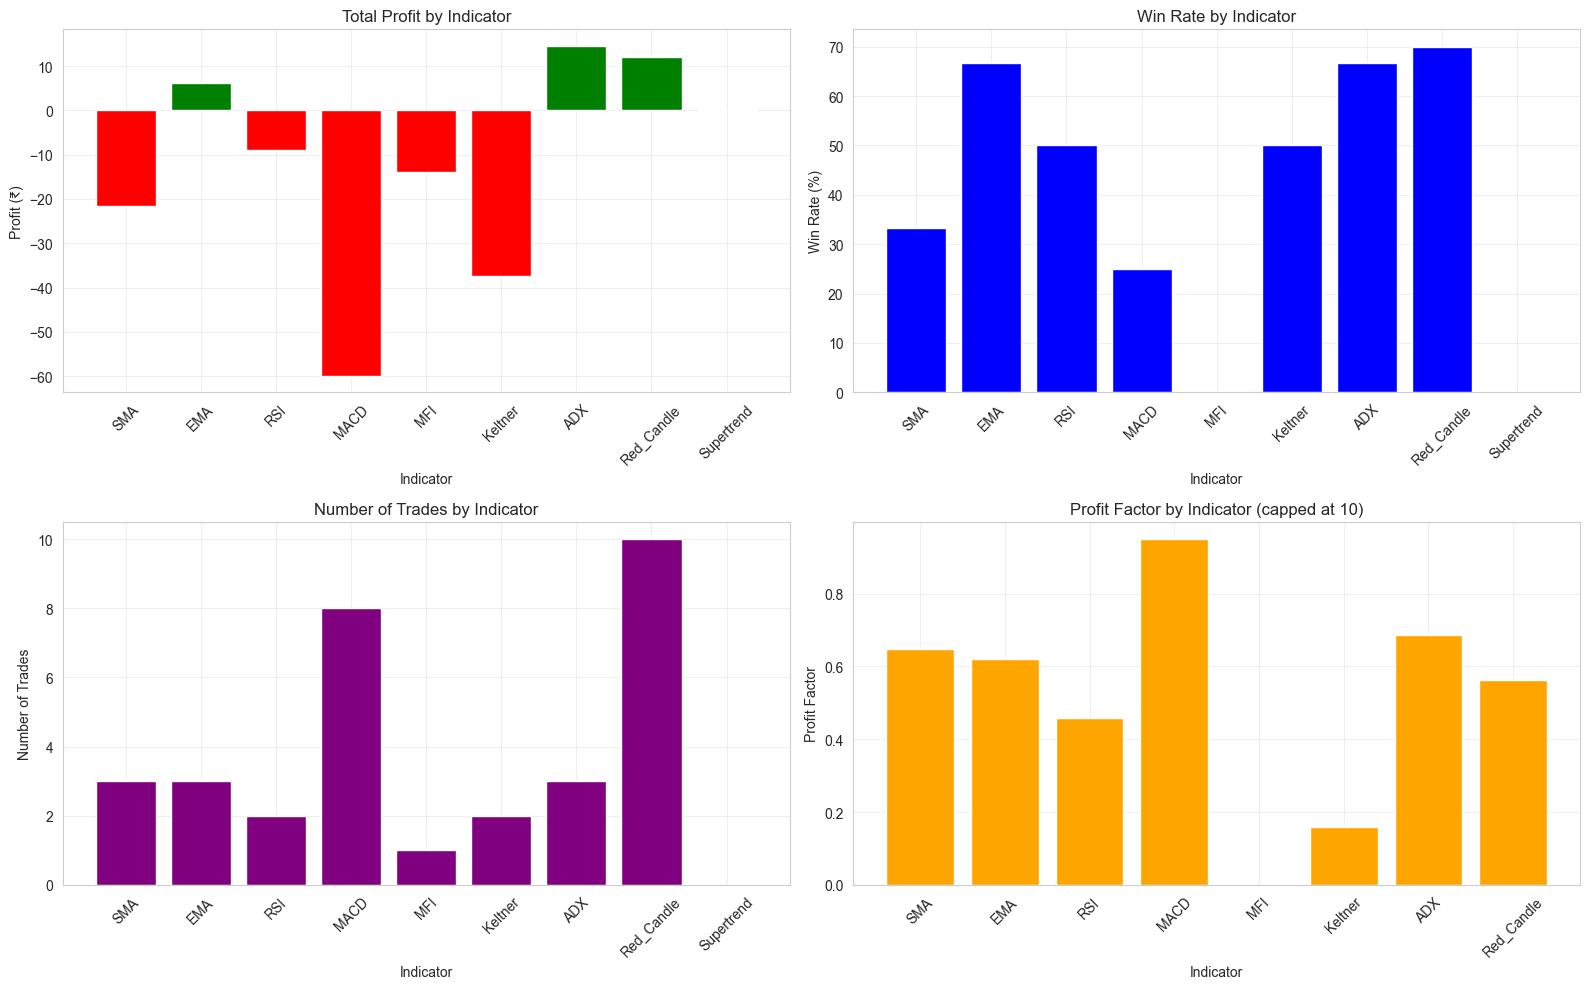

Saved backtest summary chart to SBIN_backtest_summary.png


In [51]:
# Visualize SBIN backtest summary results
try:
    # Check if summary_df exists and is not empty
    if 'summary_df' in locals() and not summary_df.empty:
        plt.figure(figsize=(16, 10))
        
        # 1. Bar chart of profit by indicator
        plt.subplot(2, 2, 1)
        colors = ['green' if p > 0 else 'red' for p in summary_df['profit']]
        plt.bar(summary_df['indicator'], summary_df['profit'], color=colors)
        plt.title('Total Profit by Indicator')
        plt.xlabel('Indicator')
        plt.ylabel('Profit (₹)')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # 2. Bar chart of win rate by indicator
        plt.subplot(2, 2, 2)
        plt.bar(summary_df['indicator'], summary_df['win_rate'], color='blue')
        plt.title('Win Rate by Indicator')
        plt.xlabel('Indicator')
        plt.ylabel('Win Rate (%)')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # 3. Bar chart of number of trades by indicator
        plt.subplot(2, 2, 3)
        plt.bar(summary_df['indicator'], summary_df['trades'], color='purple')
        plt.title('Number of Trades by Indicator')
        plt.xlabel('Indicator')
        plt.ylabel('Number of Trades')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # 4. Bar chart of profit factor by indicator
        plt.subplot(2, 2, 4)
        profit_factors = [min(pf, 10) for pf in summary_df['profit_factor']]  # Cap for better visualization
        plt.bar(summary_df['indicator'], profit_factors, color='orange')
        plt.title('Profit Factor by Indicator (capped at 10)')
        plt.xlabel('Indicator')
        plt.ylabel('Profit Factor')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig("SBIN_backtest_summary.png")
        plt.show()
        
        print("Saved backtest summary chart to SBIN_backtest_summary.png")
    else:
        print("No backtest summary data available for visualization. Please run the backtest cell first.")
    
except Exception as e:
    print(f"Error visualizing results: {e}")